# "Akiya" in Japan: Predicting the ratio of vacant houses at the municipality level across the country 

## Introduction 

&ensp;&ensp;According to the Housing and Land Survey of Japan conducted in 2018, there are more than 8 million vacant houses, called “Akiya” in Japanese, in the country, comprising approximately 13.6% of the total number of homes. The number has been increasing yearly due to a declining birthrate and ageing population along with changes in migration patterns. The inadequate management of these vacant houses leads to social problems affecting the living environment regarding disaster prevention, sanitation, and landscape (Statistics Bureau of Japan 2020). In terms of the geographical scale, although the upsurge of vacant dwellings is a nationwide issue, the social problems mentioned above should be considered at the local scale, as the balance between the construction and demolition of houses differs depending on local authorities (Kanamori et al. 2015, p.1018). Therefore, this report presents the workflow of analysis of the ratio of vacant houses across Japan at the municipality level.  

### Required Packages to Run Analysis

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rfpimp
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold 
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

## Literature review

&ensp;&ensp;There have been mainly two approaches considered in the current research around vacant homes in Japan. The first approach involves the detection of empty houses using machine learning methods. This is based on the current situation where the primary way of identifying vacant dwellings is based on on-site surveys, which require substantial time, financial resources, and labour (Sayuda et al. 2022, p.3004). The research following this approach has been conducted with different cities across Japan as areas of interest, such as Wakayama City (Baba et al., 2020; Sayuda et al., 2022) and Kagoshima City (Akiyama et al., 2018). 

&ensp;&ensp;The second approach involves the exploration of factors explaining vacant house rates. Studies taking this approach may be divided into two categories. One category is for research which analyses factors at the building level, using either statistical or machine learning methods with the development of a method focusing on the effect of attributes such as building properties and surrounding environmental factors. Along with the studies conducted taking the first type of approach, works in this category focus on a single municipality, such as Hatano City (Oda et al., 2018) and Hofu City (Mizusawa et al., 2022). This relates to the finding that most research conducted on housing vacancy in Japan is found to be focused on a local area (Mashita and Akiyama 2020, pp.3-4). However, one requires enclosed municipal data such as the Basic Resident Register, building registration, water usage data (Sayuda et al. 2022, p.3004), and vacant house field survey data, which are not made available to the public, for analysis at this level. 
The other category is where a larger area, such as a prefecture or the entire country, is of interest. For example, Hirahara (2022) conducts multiple linear regression on vacant house rates at municipalities nationwide, identifying the relationship between population characteristics such as the proportions of younger and older populations. Meanwhile, the research conducted by Yu and Lee (2023) on the factors affecting housing vacancy rates in Shizuoka Prefecture utilising publicly available data sources demonstrates that increasing housing rates is a multi-faceted issue, identifying the influence of factors relating to industry and real estate on the occurrence of vacant houses. Kanamori et al. (2015) take this approach further by considering how these models may be used to estimate future housing rates using speculative data. This demonstrates how these models may be used to identify the municipalities where the ratio of vacant houses may be expected to increase, providing crucial implications for considering appropriate strategies to be conducted (ibid., 1018). However, the estimation capability of their multiple linear regression model based on prefecture-level data is limited (ibid., p.1022).  

&ensp;&ensp;This report, placing itself in the second category within the approach examining factors relating to housing vacancy, sets the following research question: ***Can the ratio of vacant houses at the municipality level in Japan be predicted based on different regional attributes from various factors?***

## Presentation of Data
&ensp;&ensp;The table below provides the variables selected for this analysis, including an explanation if necessary, and the data source. The selection of this total of 18 variables is mainly based on previous works discussed in the literature review. The study by Yoo and Kwon (2019) on housing vacancy in South Korea has also been referred to. Although the area of interest for this analysis is different, their variable selection may be helpful as a reference due to its comprehensive review of factors leading to housing vacancy across various countries overlapping with the studies explored in the literature review (ibid.) and the similarities between the two countries in regards to their ‘super ageing societies’ (Pak and Jewell 2019), which has been identified as a contributing factor for the increase in vacant dwellings in Japan from previous research. 

&ensp;&ensp;Four types of vacant homes are identified in the Housing and Land Survey: secondary housing, rental housing, housing for sale and other housing. However, it was decided to focus on the ‘other housing’ due to its rapid increase compared to different types (Kanamori et al. 2015, p.1018) and its interest in previous works (ibid., Hirahara 2022). One limitation of using the Housing and Land Survey (2018) data is that municipalities with a population of less than 15000 are excluded from the dataset. Hence, the analysis results do not represent all municipalities, expected to have less predictive power for rural, less populated areas without data.

 


| Variable | Data Source |
| -------- | ----------- |
| ***Dependent variable*** | | 
| Proportion of vacant houses (classified as 'other housing' in the vacant housing category) | Housing and Land Survey ([2018](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200522&tstat=000001127155&cycle=0&year=20180&month=0&tclass1=000001129435&tclass2=000001129436&cycle_facet=cycle&tclass3val=0&metadata=1&data=1))|
| ***Independent variables***| |
| Population density | National Census ([2015](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200521&tstat=000001049104&cycle=0&tclass1=000001049105&tclass2val=0))|
| Population change rate between 2010 and 2015 | National Census ([2015](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200521&tstat=000001049104&cycle=0&tclass1=000001049105&tclass2val=0))|
| Proportion of younger population (age 0-14)| National Census ([2015](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200521&tstat=000001049104&cycle=0&tclass1=000001049105&tclass2val=0))|
| Proportion of working age population (age 15-64) | National Census ([2015](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200521&tstat=000001049104&cycle=0&tclass1=000001049105&tclass2val=0))|
| Proportion of elderly population (age 65 and above) | National Census ([2015](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200521&tstat=000001049104&cycle=0&tclass1=000001049105&tclass2val=0))|
| Proportion of elderly single-person households (age 65 and above) | National Census ([2015](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200521&tstat=000001049104&cycle=0&tclass1=000001049105&tclass2val=0))|
| Proportion of expenditure spent on public assistance out of total expenditure | Local Governance Finance Survey ([2017](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200251&tstat=000001077755&cycle=7&year=20170&month=0&tclass1=000001077756&tclass2=000001077757&result_back=1&tclass3val=0))|
| Employment rate | National Census ([2015](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200521&tstat=000001080615&cycle=0&tclass1=000001095955&tclass2=000001095956&tclass3=000001097355))|
| Change rate in the number of businesses between 2011 and 2016 | Economic Census ([2014](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200552&tstat=000001072573&cycle=0&tclass1=000001074966&tclass2=000001077017&tclass3val=0&metadata=1&data=1))|
| Employment scale - the number of employed workers per the number of businesses | Economic Census ([2014](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200552&tstat=000001072573&cycle=0&tclass1=000001074966&tclass2=000001077017&tclass3val=0&metadata=1&data=1))|
| Proportion of workers in the primary industry | National Census ([2015](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200521&tstat=000001049104&cycle=0&tclass1=000001049105&tclass2val=0))|
| Proportion of workers in the secondary industry | National Census ([2015](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200521&tstat=000001049104&cycle=0&tclass1=000001049105&tclass2val=0))|
| Proportion of workers in the tertiary industry | National Census ([2015](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200521&tstat=000001049104&cycle=0&tclass1=000001049105&tclass2val=0))|
| Proportion of dwellings occupied by owners | Housing and Land Survey ([2018](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200522&tstat=000001127155&cycle=0&year=20180&month=0&tclass1=000001129435&tclass2=000001129436&cycle_facet=cycle&tclass3val=0&metadata=1&data=1))|
| Distribution ratio of houses - the number of houses per the number of households | Housing and Land Survey ([2018](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200522&tstat=000001127155&cycle=0&year=20180&month=0&tclass1=000001129435&tclass2=000001129436&cycle_facet=cycle&tclass3val=0&metadata=1&data=1))|
| Proportion of old dwellings (built in 1980 or before)| Housing and Land Survey ([2018](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200522&tstat=000001127155&cycle=0&year=20180&month=0&tclass1=000001129435&tclass2=000001129436&cycle_facet=cycle&tclass3val=0&metadata=1&data=1))|
| Proportion of new dwellings (built between 2016 and 2018)| Housing and Land Survey ([2018](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200522&tstat=000001127155&cycle=0&year=20180&month=0&tclass1=000001129435&tclass2=000001129436&cycle_facet=cycle&tclass3val=0&metadata=1&data=1))|
| Proportion of detatched houses | Housing and Land Survey ([2018](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200522&tstat=000001127155&cycle=0&year=20180&month=0&tclass1=000001129435&tclass2=000001129436&cycle_facet=cycle&tclass3val=0&metadata=1&data=1))|
| Proportion of apartments| Housing and Land Survey ([2018](https://www.e-stat.go.jp/stat-search/files?page=1&layout=datalist&toukei=00200522&tstat=000001127155&cycle=0&year=20180&month=0&tclass1=000001129435&tclass2=000001129436&cycle_facet=cycle&tclass3val=0&metadata=1&data=1))|

### Data Validation and Cleaning

**Dependent Variable**

In [2]:
# Reading in the data from link
## make sure it can be accessed with link
vacant_homes = pd.read_excel("https://github.com/ntsuchiyama/CASA0006_assessment/raw/main/e001_2.xlsx", header = [5,6,8,9,10])

In [3]:
# keep columns which are necessary for analysis
vacant_homes = vacant_homes[vacant_homes.columns[[4,5,6,16]]]

In [4]:
# assign new columns names to drop levels from multi level columns & label columns in English (originally in Japanese)
vacant_homes.columns = ['region_identification_code', 'code_name', 'total_homes', 'empty_homes_other']

In [5]:
# replace the '-' in the dataframe 
vacant_homes.replace('-', np.nan, inplace = True)

# check data type of each column (in case conversion is necessary)
vacant_homes.dtypes

region_identification_code    object
code_name                     object
total_homes                    int64
empty_homes_other              int64
dtype: object

In [6]:
# create column for prefecture code 
vacant_homes['prefecture_code'] = vacant_homes['code_name'].str.slice(0, 2)

# create column for municipality code (first 5 numbers in 'code_name' column)
vacant_homes['municipality_code'] = vacant_homes['code_name'].str.slice(0, 5)

# create column for municipality name (after underbar in 'code_name' column)
vacant_homes['municipality_name'] = vacant_homes['code_name'].str.replace(r'[0-9]{5}\_', '', regex=True)

# create column for ratio of empty homes
vacant_homes['empty_homes_ratio'] = vacant_homes['empty_homes_other']/vacant_homes['total_homes']*100

In [7]:
# select rows for municipalities based on region_identification_code (values = 1, 2, 3) but keep the municipalities for tokyo
vacant_homes = vacant_homes.loc[(vacant_homes['region_identification_code'].isin([1, 2, 3]))|(vacant_homes['prefecture_code'] == "13")].drop(columns = 'region_identification_code')

In [8]:
# check final output of the data 
vacant_homes 

,code_name,total_homes,empty_homes_other,prefecture_code,municipality_code,municipality_name,empty_homes_ratio
2,01100_札幌市,1051400,44300,01,01100,札幌市,4.213430
13,01202_函館市,147610,10830,01,01202,函館市,7.336901
14,01203_小樽市,64670,5150,01,01203,小樽市,7.963507
15,01204_旭川市,181220,7530,01,01204,旭川市,4.155171
16,01205_室蘭市,49130,4120,01,01205,室蘭市,8.385915
...,...,...,...,...,...,...,...
1305,47328_中城村,8910,340,47,47328,中城村,3.815937
1306,47329_西原町,14010,340,47,47329,西原町,2.426838
1307,47348_与那原町,9010,170,47,47348,与那原町,1.886792
1308,47350_南風原町,14370,440,47,47350,南風原町,3.061935


**Independent Variables**

In [9]:
# Population density, Population change rate between 2010 and 2015, 
# Proportion of younger population (age 0-14), Proportion of working age population (age 15-64), 
# Proportion of elderly population (age 65 and above), 
# Proportion of elderly single-person households (age 65 and above) - National Census (2015)

In [10]:
# Reading in the data for the link 
# data type of the columns set as object in order to read in the municipality code correctly
socioeconomic_1 = pd.read_excel("https://github.com/ntsuchiyama/CASA0006_assessment/raw/main/2015.xls", header = [7, 8, 9, 10], dtype=object) 

In [11]:
# keep columns which are necessary for analysis and transformation of columns 
socioeconomic_1 = socioeconomic_1[socioeconomic_1.columns[[1, 11, 13, 20, 21, 22, 44, 51]]]

In [12]:
# assign new columns names to label columns in English (originally in Japanese)
socioeconomic_1.columns = ['municipality_code', 'population_change_rate', 'population_density', 'proportion_younger_pop', 'proportion_working_pop', 'proportion_elderly_pop', 'total_household', 'single_over65_household']

In [13]:
# replace the '-' in the dataframe 
socioeconomic_1.replace('-', np.nan, inplace = True)

# calculate the proportion of single elderly households
socioeconomic_1['proportion_single_elderly_household'] = socioeconomic_1['single_over65_household']/socioeconomic_1['total_household']*100

# drop the variables for the absolute numbers of households
socioeconomic_1 = socioeconomic_1.drop(columns = ["total_household", "single_over65_household"])

# check data type of the column 
socioeconomic_1.dtypes

municipality_code                       object
population_change_rate                 float64
population_density                     float64
proportion_younger_pop                 float64
proportion_working_pop                 float64
proportion_elderly_pop                 float64
proportion_single_elderly_household    float64
dtype: object

In [14]:
# check dataframe 
socioeconomic_1

,municipality_code,population_change_rate,population_density,proportion_younger_pop,proportion_working_pop,proportion_elderly_pop,proportion_single_elderly_household
0,00000,-0.751700,340.8,12.644608,60.719625,26.635767,11.114731
1,01000,-2.264375,68.6,11.354129,59.557849,29.088022,13.100124
2,01100,2.028225,1741.2,11.392053,63.684324,24.923624,11.369871
3,01101,7.919560,5119.1,10.217054,68.266545,21.516400,10.926346
4,01102,2.345927,4488.3,11.721137,63.722732,24.556131,11.004143
...,...,...,...,...,...,...,...
1960,47361,-8.968189,121.8,15.726275,57.779212,26.494513,12.648810
1961,47362,8.938945,1078.1,18.367488,62.245568,19.386944,7.376537
1962,47375,-3.005686,54.3,17.420436,56.197655,26.381910,10.851064
1963,47381,3.601969,12.0,17.228275,62.553838,20.217887,9.900990


In [15]:
# Proportion of expenditure spent on public assistance out of total expenditure	
# - Local Governance Finance Survey (2017)

In [16]:
# Reading in the data from link 
socioeconomic_2 = pd.read_csv("https://github.com/ntsuchiyama/CASA0006_assessment/raw/main/a0010201761190100.csv", encoding = 'shift-jis') 

In [17]:
# subset dataframe to necessary columns 
# we are using municipality name instead of the code because the code differs from the assigned code for vacant homes
socioeconomic_2 = socioeconomic_2[socioeconomic_2.columns[[2, 4, 66]]]

In [18]:
# assign new columns names to label columns in English (originally in Japanese)
socioeconomic_2.columns = ['municipality_code_new', 'municipality_name', 'total_public_assistance_fee']

In [19]:
# make all values for "municipality_code_new" 6 digits
socioeconomic_2.loc[:, 'municipality_code_new'] = socioeconomic_2.loc[:, 'municipality_code_new'].str.zfill(6)

# create column for prefecture code 
socioeconomic_2.loc[:, 'prefecture_code'] = socioeconomic_2.loc[:, 'municipality_code_new'].str.slice(0, 2)

In [20]:
# check data type of columns 
socioeconomic_2.dtypes

municipality_code_new          object
municipality_name              object
total_public_assistance_fee     int64
prefecture_code                object
dtype: object

In [21]:
# check dataframe
socioeconomic_2

,municipality_code_new,municipality_name,total_public_assistance_fee,prefecture_code
0,011002,札幌市,129237244,01
1,012025,函館市,20854178,01
2,012033,小樽市,8241395,01
3,012041,旭川市,20596113,01
4,012050,室蘭市,5624637,01
...,...,...,...,...
3159,478423,那覇市・南風原町環境施設組合,0,47
3160,478431,那覇港管理組合,0,47
3161,478440,沖縄県介護保険広域連合,0,47
3162,478458,沖縄県後期高齢者医療広域連合,0,47


In [22]:
# Reading in the data from link 
## make sure it can be accessed with link
socioeconomic_2_sub = pd.read_csv("https://github.com/ntsuchiyama/CASA0006_assessment/raw/main/a0010201761132100.csv", encoding = "SHIFT_JIS") 

In [23]:
# subset dataframe to necessary columns 
# we are using municipality name instead of the code for the same reason as above
socioeconomic_2_sub = socioeconomic_2_sub[socioeconomic_2_sub.columns[[2, 4, 8, 10]]]

In [24]:
# assign new columns names to label columns in English (originally in Japanese)
socioeconomic_2_sub.columns = ['municipality_code_new', 'municipality_name', 'expenditure_type', 'total_expenditure']

In [25]:
# subset to rows for total expenditure (expenditure type = 38) and drop the column
socioeconomic_2_sub = socioeconomic_2_sub.loc[(socioeconomic_2_sub['expenditure_type'] == "38")].drop(columns = ['expenditure_type'])

# make all values for "municipality_code_new" 6 digits
socioeconomic_2_sub.loc[:, 'municipality_code_new'] = socioeconomic_2_sub.loc[:, 'municipality_code_new'].str.zfill(6)

# create column for prefecture code 
socioeconomic_2_sub.loc[:, 'prefecture_code'] = socioeconomic_2_sub.loc[:, 'municipality_code_new'].str.slice(0, 2)

# check data type of the column 
socioeconomic_2_sub.dtypes

municipality_code_new    object
municipality_name        object
total_expenditure        object
prefecture_code          object
dtype: object

In [26]:
# check dataframe
socioeconomic_2_sub

,municipality_code_new,municipality_name,total_expenditure,prefecture_code
53805,011002,札幌市,966533376,01
53806,012025,函館市,140296035,01
53807,012033,小樽市,57105770,01
53808,012041,旭川市,157702125,01
53809,012050,室蘭市,45343862,01
...,...,...,...,...
56964,478423,那覇市・南風原町環境施設組合,5040013,47
56965,478431,那覇港管理組合,5936328,47
56966,478440,沖縄県介護保険広域連合,565824,47
56967,478458,沖縄県後期高齢者医療広域連合,107270,47


In [27]:
# merge the two dataframes for the calculation of the proportion of expenditure spent on public assistance
socioeconomic_2 = socioeconomic_2.merge(socioeconomic_2_sub, on=['prefecture_code', 'municipality_name'], how='left')

# change column type for 'total_expenditure' to numeric
socioeconomic_2['total_expenditure'] = socioeconomic_2['total_expenditure'].apply(pd.to_numeric)

# create column of the proportion
socioeconomic_2['proportion_public_assistance'] = socioeconomic_2['total_public_assistance_fee']/socioeconomic_2['total_expenditure']*100

# check dataframe
socioeconomic_2

,municipality_code_new_x,municipality_name,total_public_assistance_fee,prefecture_code,municipality_code_new_y,total_expenditure,proportion_public_assistance
0,011002,札幌市,129237244,01,011002,966533376,13.371214
1,012025,函館市,20854178,01,012025,140296035,14.864410
2,012033,小樽市,8241395,01,012033,57105770,14.431808
3,012041,旭川市,20596113,01,012041,157702125,13.060137
4,012050,室蘭市,5624637,01,012050,45343862,12.404407
...,...,...,...,...,...,...,...
3159,478423,那覇市・南風原町環境施設組合,0,47,478423,5040013,0.000000
3160,478431,那覇港管理組合,0,47,478431,5936328,0.000000
3161,478440,沖縄県介護保険広域連合,0,47,478440,565824,0.000000
3162,478458,沖縄県後期高齢者医療広域連合,0,47,478458,107270,0.000000


In [28]:
# Employment rate - National Census (2015)

In [29]:
# Reading in the data from link
## make sure it can be accessed with link
socioeconomic_3 = pd.read_csv("https://github.com/ntsuchiyama/CASA0006_assessment/raw/main/00130_00.csv", header = [9, 10], encoding = "shift_jisx0213")

In [30]:
# subset dataframe to necessary columns 
# we are using municipality name instead of the code because the code differs from the assigned code for vacant homes
socioeconomic_3 = socioeconomic_3[socioeconomic_3.columns[[2, 6, 7]]]

In [31]:
# assign new columns names to label columns in English (originally in Japanese)
socioeconomic_3.columns = ['municipality_code', 'labour_force_pop', 'employed_pop']

In [32]:
# make all values for "municipality_code" 5 digits
socioeconomic_3.loc[:, 'municipality_code'] = socioeconomic_3.loc[:, 'municipality_code'].astype(str).str.zfill(5)

In [33]:
# check datatypes 
socioeconomic_3.dtypes

municipality_code    object
labour_force_pop     object
employed_pop         object
dtype: object

In [34]:
# replace the '-' in the dataframe 
socioeconomic_3.replace('-', np.nan, inplace = True)

# transform 'labour_force_pop' and 'unemployed_pop' columns into numeric values
socioeconomic_3[['labour_force_pop', 'employed_pop']] = socioeconomic_3[['labour_force_pop', 'employed_pop']].apply(pd.to_numeric)

# create new column for unemployment rate
socioeconomic_3['employment_rate'] = socioeconomic_3['employed_pop']/socioeconomic_3['labour_force_pop']*100

In [35]:
# check dataframe 
socioeconomic_3

,municipality_code,labour_force_pop,employed_pop,employment_rate
0,00000,61523327.0,58919036.0,95.766986
1,01000,2553043.0,2435098.0,95.380219
2,01100,892932.0,844313.0,94.555128
3,01101,108064.0,102279.0,94.646691
4,01102,129316.0,122701.0,94.884624
...,...,...,...,...
1974,47361,4199.0,3918.0,93.307930
1975,47362,13418.0,12432.0,92.651662
1976,47375,669.0,621.0,92.825112
1977,47381,2376.0,2338.0,98.400673


In [36]:
# Change rate in the number of businesses between 2011 and 2016
# Employment scale - the number of employed workers per the number of businesses
# - Economic Census (2014)

In [37]:
# Reading in the data from link
socioeconomic_4= pd.read_csv("https://github.com/ntsuchiyama/CASA0006_assessment/raw/main/36000.csv", header = [9, 10], encoding = "shift_jisx0213")

In [38]:
# subset dataframe to necessary columns 
# we are using municipality name instead of the code because the code differs from the assigned code for vacant homes
socioeconomic_4 = socioeconomic_4[socioeconomic_4.columns[[1, 11, 13, 14, 15]]]

In [39]:
# assign new columns names to label columns in English (originally in Japanese)
socioeconomic_4.columns = ['municipality_code', 'total_businesses', 'new_businesses', 'closed_businesses', 'total_employees']

In [40]:
# extract last 5 characters for "municipality_code" column and reassign 
socioeconomic_4['municipality_code'] = socioeconomic_4['municipality_code'].str[-5:]

In [41]:
# check datatypes 
socioeconomic_4.dtypes

municipality_code    object
total_businesses     object
new_businesses       object
closed_businesses    object
total_employees      object
dtype: object

In [42]:
# replace the '-' and '...' in the dataframe 
socioeconomic_4.replace(['...', '-'], np.nan, inplace = True)

# transform 'labour_force_pop' and 'unemployed_pop' columns into numeric values
socioeconomic_4[['total_businesses', 'new_businesses', 'closed_businesses', 'total_employees']] = socioeconomic_4[['total_businesses', 'new_businesses', 'closed_businesses', 'total_employees']].apply(pd.to_numeric)

# create new column for change rate of businesess
socioeconomic_4['business_change_rate'] = (socioeconomic_4['new_businesses']-socioeconomic_4['closed_businesses'])/(socioeconomic_4['total_businesses'] + socioeconomic_4['closed_businesses'] - socioeconomic_4['new_businesses'])*100

# create new column for employment scale 
socioeconomic_4['employment_scale'] = socioeconomic_4['total_employees']/socioeconomic_4['total_businesses']

In [43]:
# check the dataframe 
socioeconomic_4

,municipality_code,total_businesses,new_businesses,closed_businesses,total_employees,business_change_rate,employment_scale
0,00000,5541634.0,859962.0,872366.0,57427704.0,-0.223333,10.362955
1,01000,233037.0,35724.0,37591.0,2206038.0,-0.794793,9.466471
2,01100,75749.0,14392.0,14229.0,858119.0,0.215648,11.328453
3,01101,22955.0,5159.0,5163.0,300860.0,-0.017422,13.106513
4,01102,9219.0,1651.0,1626.0,105286.0,0.271916,11.420545
...,...,...,...,...,...,...,...
2287,47370,66.0,7.0,5.0,209.0,3.125000,3.166667
2288,47375,66.0,7.0,5.0,209.0,3.125000,3.166667
2289,47380,651.0,72.0,81.0,2653.0,-1.363636,4.075269
2290,47381,438.0,41.0,44.0,1955.0,-0.680272,4.463470


In [44]:
# Proportion of workers in the primary industry 
# Proportion of workers in the secondary industry 
# Proportion of workers in the tertiary industry - National Census (2015)

In [45]:
# Reading in the data for the link 
# data type of the columns set as object in order to read in the municipality code correctly
socioeconomic_5 = pd.read_excel("https://github.com/ntsuchiyama/CASA0006_assessment/raw/main/2015.xls", sheet_name = 1, header = [7, 8, 9, 10, 11], dtype=object)

In [46]:
# keep columns which are necessary for analysis and transformation of columns 
socioeconomic_5 = socioeconomic_5[socioeconomic_5.columns[[1, 42, 43, 44]]]

In [47]:
# assign new columns names to label columns in English (originally in Japanese)
socioeconomic_5.columns = ['municipality_code', 'proportion_primary_industry', 'proportion_secondary_industry', 'proportion_tertiary_industry']

In [48]:
# replace the '-' in the dataframe 
socioeconomic_5.replace('-', np.nan, inplace = True)

In [49]:
# check datatypes 
socioeconomic_5.dtypes

municipality_code                 object
proportion_primary_industry      float64
proportion_secondary_industry    float64
proportion_tertiary_industry     float64
dtype: object

In [50]:
# check the dataframe
socioeconomic_5

,municipality_code,proportion_primary_industry,proportion_secondary_industry,proportion_tertiary_industry
0,00000,3.984603,24.966926,71.048471
1,01000,7.405404,17.893075,74.701521
2,01100,0.493386,15.426844,84.079770
3,01101,0.302122,9.582533,90.115345
4,01102,0.593233,17.439627,81.967140
...,...,...,...,...
1960,47361,27.081732,14.809121,58.109147
1961,47362,9.043608,16.699703,74.256690
1962,47375,41.612903,13.387097,45.000000
1963,47381,16.524621,5.303030,78.172348


In [51]:
# Proportion of dwellings occupied by owners
# Distribution ratio of houses - the number of houses per the number of households
# - Housing and Land Survey (2018)

In [52]:
# Reading in the data from link
## make sure it can be accessed with link
real_estate_1 = pd.read_excel("https://github.com/ntsuchiyama/CASA0006_assessment/raw/main/e003_2.xlsx", header = [5,6,8,9,10])

In [53]:
# keep columns which are necessary for analysis and transformation of columns 
real_estate_1 = real_estate_1[real_estate_1.columns[[5,7,8,9]]]

In [54]:
# assign new columns names to drop levels from multi level columns & label columns in English (originally in Japanese)
real_estate_1.columns = ['code_name', 'home_ownership', 'total_houses', 'total_households']

In [55]:
# check data type of each column (in case conversion is necessary)
real_estate_1.dtypes

code_name           object
home_ownership      object
total_houses         int64
total_households     int64
dtype: object

In [56]:
# rename values in 'home_ownership' column into English for further conversion
real_estate_1['home_ownership'] = real_estate_1['home_ownership'].map({'0_総数': 'total', '1_持ち家': 'owned', '2_借家': 'rent'})

In [57]:
real_estate_1

,code_name,home_ownership,total_houses,total_households
0,00000_全国,total,53616300,53925000
1,00000_全国,owned,32801500,33042900
2,00000_全国,rent,19064700,19124700
3,01000_北海道,total,2416700,2433500
4,01000_北海道,owned,1359400,1373400
...,...,...,...,...
3925,47350_南風原町,owned,6230,6240
3926,47350_南風原町,rent,6270,6270
3927,47362_八重瀬町,total,10280,10360
3928,47362_八重瀬町,owned,7000,7080


In [58]:
# calculation of the distribtuion ratio of house
real_estate_1['house_distribution_ratio'] = real_estate_1['total_houses']/real_estate_1['total_households']

In [59]:
# create pivot table for calculation of the proportion of owned houses
real_estate_1_sub = real_estate_1.pivot_table('total_houses', 'code_name', 'home_ownership')
real_estate_1_sub = real_estate_1_sub.rename_axis(None, axis=1).reset_index()

# create column based on calculation 
real_estate_1_sub['proportion_owned'] = real_estate_1_sub['owned']/real_estate_1_sub['total']*100

# check data frame
real_estate_1_sub

,code_name,owned,rent,total,proportion_owned
0,00000_全国,32801500,19064700,53616300,61.178224
1,01000_北海道,1359400,998600,2416700,56.250259
2,01100_札幌市,447900,445500,920900,48.637203
3,01101_札幌市 中央区,50540,73410,128350,39.376704
4,01102_札幌市 北区,69040,61750,134540,51.315594
...,...,...,...,...,...
1305,47328_中城村,4180,3650,8130,51.414514
1306,47329_西原町,6510,6120,12960,50.231481
1307,47348_与那原町,3870,3520,7850,49.299363
1308,47350_南風原町,6230,6270,13250,47.018868


In [60]:
# subset pivot table to necessary columns for merge
real_estate_1_sub = real_estate_1_sub[['code_name', 'proportion_owned']]

# subset original dataframe to total value for 'home_ownership' column and drop
real_estate_1 = real_estate_1.loc[real_estate_1['home_ownership'] == "total"].drop(columns=['home_ownership'])

# merge with orignal real estate dataframe
real_estate_1 = real_estate_1.merge(real_estate_1_sub, on='code_name', how='left')

In [61]:
# check dataframe
real_estate_1

,code_name,total_houses,total_households,house_distribution_ratio,proportion_owned
0,00000_全国,53616300,53925000,0.994275,61.178224
1,01000_北海道,2416700,2433500,0.993096,56.250259
2,01100_札幌市,920900,927700,0.992670,48.637203
3,01101_札幌市 中央区,128350,128950,0.995347,39.376704
4,01102_札幌市 北区,134540,135420,0.993502,51.315594
...,...,...,...,...,...
1305,47328_中城村,8130,8130,1.000000,51.414514
1306,47329_西原町,12960,13040,0.993865,50.231481
1307,47348_与那原町,7850,7900,0.993671,49.299363
1308,47350_南風原町,13250,13270,0.998493,47.018868


In [62]:
# Proportion of old dwellings (built in 1980 or before)
# Proportion of new dwellings (built between 2016 and 2018)
# Proportion of detatched houses, Proportion of apartments - Housing and Land Survey (2018)

In [63]:
# Reading in the data from link 
## make sure it can be accessed with link
real_estate_2= pd.read_excel("https://github.com/ntsuchiyama/CASA0006_assessment/raw/main/e010_2.xlsx", header = [5,6,8,9,10])

In [64]:
# keep columns which are necessary for analysis and transformation of columns 
real_estate_2 = real_estate_2[real_estate_2.columns[[5,7,9,11,12,13,14,19]]]

In [65]:
# assign new columns names to drop levels from multi level columns & label columns in English (originally in Japanese)
real_estate_2.columns = ['code_name', 'building_structure', 'building_style', 'building_floors', 'total_houses', 'built_before_1970', 'built_1971_1980', 'built_2016_2018']

In [66]:
# select rows which refer to the total values for 'building structure' and 'building floors' and drop the columns 
real_estate_2 = real_estate_2.loc[(real_estate_2['building_structure'] == '0_総数') & (real_estate_2['building_floors'] == '00_総数')].drop(columns=['building_structure', 'building_floors'])

In [67]:
# check data type of each column (in case conversion is necessary)
real_estate_2.dtypes

code_name            object
building_style       object
total_houses         object
built_before_1970    object
built_1971_1980      object
built_2016_2018      object
dtype: object

In [68]:
# rename values in 'building_style' column into English for further conversion
real_estate_2['building_style'] = real_estate_2['building_style'].map({'0_総数': 'total', '1_一戸建': 'detached', '2_長屋建': 'tenement', '3_共同住宅': 'apartment', '4_その他': 'other'})

In [69]:
# check data frame
real_estate_2

,code_name,building_style,total_houses,built_before_1970,built_1971_1980,built_2016_2018
0,00000_全国,total,53616300,4564600,7446800,2216400
1,00000_全国,detached,28758600,3649100,4779200,1097300
2,00000_全国,tenement,1369200,175500,195100,76600
3,00000_全国,apartment,23352700,723500,2450100,1040400
7,00000_全国,other,135900,16500,22300,2200
...,...,...,...,...,...,...
31416,47362_八重瀬町,total,10280,570,1570,730
31417,47362_八重瀬町,detached,6860,570,1390,410
31418,47362_八重瀬町,tenement,220,-,90,-
31419,47362_八重瀬町,apartment,3170,-,70,320


In [70]:
# replace the '-' in the data frame 
real_estate_2.replace('-', np.nan, inplace = True)

In [71]:
# create column for the proportion of old houses (built before 1980 - based on oldest earthquake resistance criterion)
real_estate_2['proportion_old_housing'] = (real_estate_2['built_before_1970'] + real_estate_2['built_1971_1980'])/real_estate_2['total_houses']*100

real_estate_2['proportion_new_housing'] = real_estate_2['built_2016_2018']/real_estate_2['total_houses']*100

In [72]:
# create pivot table for calculation of the proportions of detached houses and apartments
real_estate_2_sub = real_estate_2.pivot_table('total_houses', 'code_name', 'building_style')
real_estate_2_sub = real_estate_2_sub.rename_axis(None, axis=1).reset_index()

# create columns based on calculation 
real_estate_2_sub['proportion_detached'] = real_estate_2_sub['detached']/real_estate_2_sub['total']*100
real_estate_2_sub['proportion_apartment'] = real_estate_2_sub['apartment']/real_estate_2_sub['total']*100

# check data frame
real_estate_2_sub

,code_name,apartment,detached,other,tenement,total,proportion_detached,proportion_apartment
0,00000_全国,23352700.0,28758600.0,135900.0,1369200.0,53616300.0,53.637793,43.555225
1,01000_北海道,1058000.0,1255600.0,7400.0,95800.0,2416700.0,51.955145,43.778707
2,01100_札幌市,592000.0,310000.0,1800.0,17200.0,920900.0,33.662721,64.284939
3,01101_札幌市 中央区,113810.0,13870.0,120.0,550.0,128350.0,10.806389,88.671601
4,01102_札幌市 北区,73800.0,57150.0,310.0,3280.0,134540.0,42.478073,54.853575
...,...,...,...,...,...,...,...,...
1305,47328_中城村,3730.0,3990.0,90.0,310.0,8130.0,49.077491,45.879459
1306,47329_西原町,7010.0,5600.0,210.0,160.0,12960.0,43.209877,54.089506
1307,47348_与那原町,4870.0,2860.0,80.0,40.0,7850.0,36.433121,62.038217
1308,47350_南風原町,7760.0,5410.0,30.0,50.0,13250.0,40.830189,58.566038


In [73]:
# subset pivot table to necessary columns for merge
real_estate_2_sub = real_estate_2_sub[['code_name', 'proportion_detached', 'proportion_apartment']]

# subset original dataframe to total value for 'home_ownership' column and drop
real_estate_2 = real_estate_2.loc[real_estate_2['building_style'] == "total"].drop(columns=['building_style'])

# merge with orignal real estate dataframe
real_estate_2 = real_estate_2.merge(real_estate_2_sub, on='code_name', how='left')

In [74]:
# check dataframe 
real_estate_2.head(5)

,code_name,total_houses,built_before_1970,built_1971_1980,built_2016_2018,proportion_old_housing,proportion_new_housing,proportion_detached,proportion_apartment
0,00000_全国,53616300.0,4564600.0,7446800.0,2216400.0,22.402516,4.133818,53.637793,43.555225
1,01000_北海道,2416700.0,125000.0,362500.0,96600.0,20.172136,3.997186,51.955145,43.778707
2,01100_札幌市,920900.0,20600.0,101600.0,44000.0,13.269628,4.777935,33.662721,64.284939
3,01101_札幌市 中央区,128350.0,2910.0,12450.0,6580.0,11.967277,5.126607,10.806389,88.671601
4,01102_札幌市 北区,134540.0,3450.0,13250.0,6010.0,12.412665,4.467073,42.478073,54.853575


In [75]:
# merge all dataframes into one final dataframe one by one
df_merged = vacant_homes.merge(socioeconomic_1, on = "municipality_code", how = "left").merge(socioeconomic_2, on = ["prefecture_code", "municipality_name"], how = "left").merge(socioeconomic_3, on = "municipality_code", how = "left").merge(socioeconomic_4, on = "municipality_code", how = "left").merge(socioeconomic_5, on = "municipality_code", how = "left").merge(real_estate_1, on = "code_name", how = "left").merge(real_estate_2, on = "code_name", how = "left")

# select columns for final dataframe
columns = ["municipality_code", "empty_homes_ratio", "population_density", "proportion_younger_pop", "proportion_working_pop", "proportion_elderly_pop", "proportion_single_elderly_household", "proportion_public_assistance", "employment_rate", "business_change_rate", "employment_scale", 'proportion_primary_industry', 'proportion_secondary_industry', 'proportion_tertiary_industry', "house_distribution_ratio", "proportion_owned", "proportion_old_housing", "proportion_new_housing", "proportion_detached", "proportion_apartment"]

# subset merged dataframes to selected columns and set index to municipality_code
df = df_merged[columns].set_index("municipality_code")

# check output
df

,empty_homes_ratio,population_density,proportion_younger_pop,proportion_working_pop,proportion_elderly_pop,proportion_single_elderly_household,proportion_public_assistance,employment_rate,business_change_rate,employment_scale,proportion_primary_industry,proportion_secondary_industry,proportion_tertiary_industry,house_distribution_ratio,proportion_owned,proportion_old_housing,proportion_new_housing,proportion_detached,proportion_apartment
municipality_code,,,,,,,,,,,,,,,,,,,
01100,4.213430,1741.2,11.392053,63.684324,24.923624,11.369871,13.371214,94.555128,0.215648,11.328453,0.493386,15.426844,84.079770,0.992670,48.637203,13.269628,4.777935,33.662721,64.284939
01202,7.336901,392.4,10.229775,57.369842,32.400383,16.294248,14.864410,94.703095,-1.847541,8.459093,3.757254,17.700964,78.541782,0.995701,57.156823,21.409369,2.517312,55.454175,39.437882
01203,7.963507,500.0,9.177018,53.658156,37.164826,19.141395,14.431808,94.337923,-2.029368,8.729033,1.445234,18.134631,80.420136,0.988323,67.704426,29.726182,1.987997,61.027757,34.452363
01204,4.155171,454.2,11.095093,57.134372,31.770535,14.431316,13.060137,95.191839,-1.505205,9.443180,2.782241,17.797045,79.420714,0.990547,58.564025,24.573379,3.653141,59.265580,37.688029
01205,8.385915,1095.0,10.401096,55.493274,34.105630,16.756248,12.404407,95.013123,-5.325704,10.049977,0.977607,26.136364,72.886029,0.993314,55.447519,35.776614,3.290950,57.566692,39.815507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47328,3.815937,1252.7,17.406355,64.753294,17.840351,6.033644,0.000000,93.837296,6.521739,9.641399,3.380615,18.924350,77.695035,1.000000,51.414514,13.899139,9.963100,49.077491,45.879459
47329,2.426838,2170.3,16.845955,65.034283,18.119762,6.492786,0.000000,94.286825,1.309707,12.894297,1.912766,17.367048,80.720185,0.993865,50.231481,13.966049,6.018519,43.209877,54.089506
47348,1.886792,3554.1,18.856891,62.617235,18.525874,8.084132,0.000000,93.866981,2.844950,7.157676,1.788062,15.921641,82.290297,0.993671,49.299363,16.050955,3.949045,36.433121,62.038217


#### Exploration of the data
&ensp;&ensp;The following are some outputs, including the sum of missing values, summary statistics, histograms, and correlation plots between the variables. The impact of imputation with the mean should not be extremely harmful because of the small number of missing values compared to the entire dataset. However, one should be aware that it may not be a representative value for variables with skewed distributions, such as the distribution ratio of houses and the proportion of new dwellings, as identified in their histograms and high skewness values. The correlation plots show that although, in general, collinearity seems to be relatively minor, some variables can be identified as having a strong correlation coefficient, such as the negative relationship between the proportion of detached houses and the proportion of apartments.  


In [76]:
# how many rows and columns does the dataframe have 
df.shape

(1088, 19)

In [77]:
# the number of missing values in each row
df.isnull().sum()

empty_homes_ratio                      0
population_density                     2
proportion_younger_pop                 2
proportion_working_pop                 2
proportion_elderly_pop                 2
proportion_single_elderly_household    2
proportion_public_assistance           6
employment_rate                        2
business_change_rate                   2
employment_scale                       2
proportion_primary_industry            2
proportion_secondary_industry          2
proportion_tertiary_industry           2
house_distribution_ratio               0
proportion_owned                       0
proportion_old_housing                 0
proportion_new_housing                 0
proportion_detached                    0
proportion_apartment                   0
dtype: int64

In [78]:
# check data type 
df.dtypes

empty_homes_ratio                      float64
population_density                     float64
proportion_younger_pop                 float64
proportion_working_pop                 float64
proportion_elderly_pop                 float64
proportion_single_elderly_household    float64
proportion_public_assistance           float64
employment_rate                        float64
business_change_rate                   float64
employment_scale                       float64
proportion_primary_industry            float64
proportion_secondary_industry          float64
proportion_tertiary_industry           float64
house_distribution_ratio               float64
proportion_owned                       float64
proportion_old_housing                 float64
proportion_new_housing                 float64
proportion_detached                    float64
proportion_apartment                   float64
dtype: object

In [79]:
# provide summary statistics of the data
df.describe()

,empty_homes_ratio,population_density,proportion_younger_pop,proportion_working_pop,proportion_elderly_pop,proportion_single_elderly_household,proportion_public_assistance,employment_rate,business_change_rate,employment_scale,proportion_primary_industry,proportion_secondary_industry,proportion_tertiary_industry,house_distribution_ratio,proportion_owned,proportion_old_housing,proportion_new_housing,proportion_detached,proportion_apartment
count,1088.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1082.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1086.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000,1088.000000
mean,7.767805,1633.095488,12.556631,58.243787,29.199582,11.380535,3.491332,95.752002,-0.685423,9.341482,6.765891,27.044844,66.189265,0.994504,71.304618,27.299408,3.799647,70.713860,26.129516
std,4.599108,3067.449262,1.938233,4.331625,5.609127,3.471798,3.616750,1.072007,3.904628,2.570501,6.460698,7.524472,8.983523,0.005934,11.963033,9.473306,2.140132,17.406751,17.439880
min,0.354698,11.600000,5.655469,41.357234,15.519089,4.581009,0.000000,86.250502,-10.018553,4.776711,0.044574,9.766728,41.139062,0.871666,32.292702,5.812574,0.503356,3.299204,0.438596
25%,4.434351,157.925000,11.339862,55.282528,25.336347,8.964428,0.604176,95.223296,-2.655148,7.720162,1.850286,21.379468,59.504211,0.992362,64.361888,19.959340,2.568463,61.613778,13.243043
50%,6.792326,441.300000,12.486644,58.675279,28.685160,10.850042,2.657833,95.870572,-1.109598,8.955769,4.446535,26.715582,65.449300,0.995708,72.880343,26.063536,3.457737,74.485099,21.991269
75%,10.164045,1464.975000,13.699143,61.173185,33.089446,13.050090,5.046936,96.464592,0.702520,10.431226,9.685660,32.248448,72.787015,0.997988,79.617552,33.839341,4.539543,83.542863,34.980345
max,30.016313,22380.200000,20.726757,71.952302,51.879874,28.487426,21.516792,98.700545,77.409639,36.018433,39.983325,51.970213,90.188698,1.000000,98.272884,64.726631,39.781329,99.548533,95.200621


array([[<AxesSubplot:title={'center':'empty_homes_ratio'}>]], dtype=object)

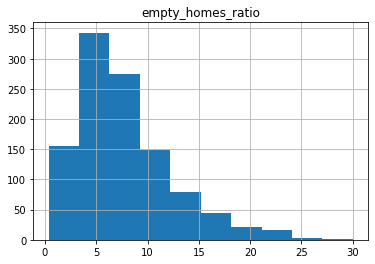

In [80]:
# create histogram for the dependent variable
df.hist("empty_homes_ratio")

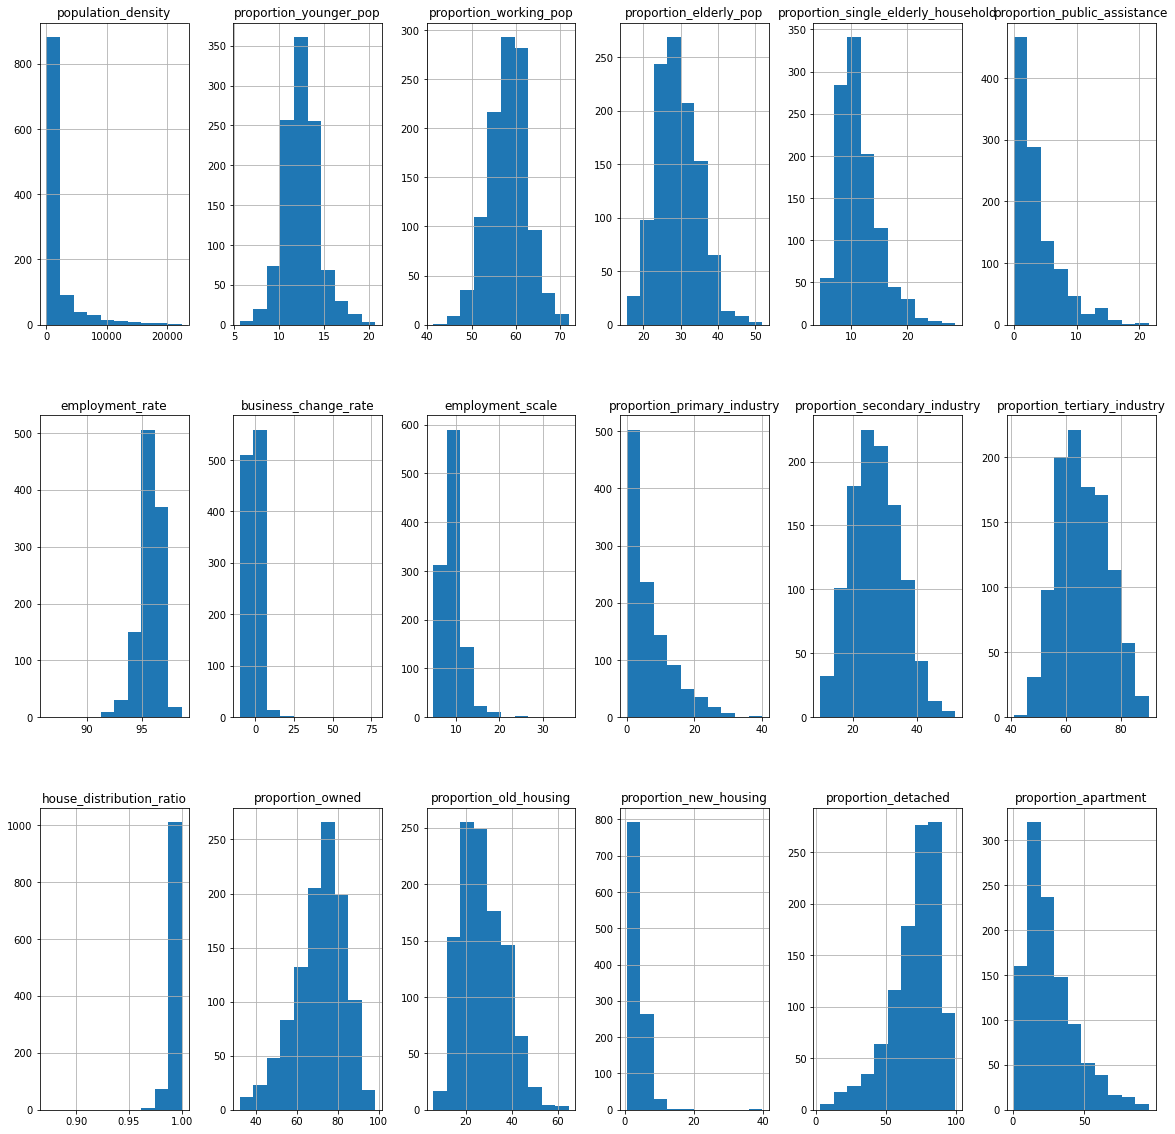

In [81]:
# create histogram for independent variables 
fig, axes = plt.subplots(3, 6, figsize = (20, 20))
indep = df.drop('empty_homes_ratio', axis=1)
indep.hist(ax = axes);

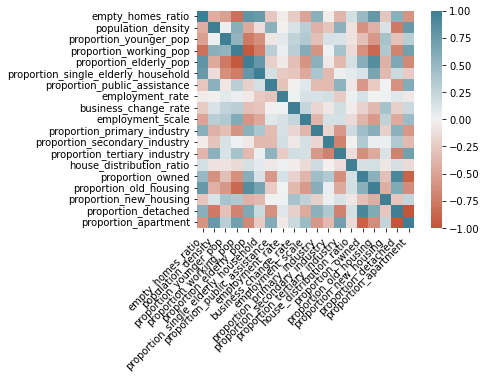

In [82]:
# plotting the heatmap for correlation
ax = sns.heatmap(df.corr(),  
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#### Spacial visualisation
&ensp;&ensp;It may be insightful to see how the proportion of vacant houses differs across Japan. This is done using the shapefile provided by [Esri Japan](https://www.esrij.com/products/japan-shp/), merging the cleaned geodataframe with the dataset created. 

In [83]:
# preparation of the data 
# Read in the datafile
gdf_raw = gpd.read_file("japan_ver84/japan_ver84.shp")

In [84]:
# check the data 
gdf_raw.head()

,JCODE,KEN,SICHO,GUN,SEIREI,SIKUCHOSON,CITY_ENG,P_NUM,H_NUM,Shape_Leng,Shape_Area,geometry
0,01101,北海道,石狩振興局,None,札幌市,中央区,"Sapporo-shi, Chuo-ku",239944,146024,0.542590,0.005128,"POLYGON ((141.34233 43.06682, 141.35520 43.068..."
1,01102,北海道,石狩振興局,None,札幌市,北区,"Sapporo-shi, Kita-ku",286054,153908,0.567773,0.007031,"POLYGON ((141.40839 43.18395, 141.40427 43.182..."
2,01103,北海道,石狩振興局,None,札幌市,東区,"Sapporo-shi, Higashi-ku",262298,144421,0.397203,0.006289,"POLYGON ((141.44698 43.15513, 141.44860 43.153..."
3,01104,北海道,石狩振興局,None,札幌市,白石区,"Sapporo-shi, Shiroishi-ku",214050,124710,0.308211,0.003815,"POLYGON ((141.46569 43.10000, 141.46812 43.097..."
4,01105,北海道,石狩振興局,None,札幌市,豊平区,"Sapporo-shi, Toyohira-ku",224435,129875,0.428316,0.005101,"POLYGON ((141.38479 43.04660, 141.38558 43.047..."


In [85]:
# split the geodataframe to two - one for designated cities, the other for other cities 
gdf_designated = gdf_raw[gdf_raw['SEIREI'].notnull()]
gdf_other = gdf_raw[gdf_raw["SEIREI"].isnull()]

In [86]:
# aggregate the ward boundaries for each designated city
gdf_designated = gdf_designated.dissolve(by='SEIREI').reset_index()

In [87]:
# replace the last number for "JCODE" with 0
gdf_designated['JCODE'] = gdf_designated['JCODE'].str[:4] + '0' 

In [88]:
# replace "SIKUCHOSON" column (municipality name in Japanese) with the designated city name
gdf_designated['SIKUCHOSON'] = gdf_designated['SEIREI']

In [89]:
# concatenate the edited dataframe for designated cities and the dataframe for other cities
gdf = pd.concat([gdf_other, gdf_designated])

In [90]:
# subset to necessary columns 
gdf = gdf[['JCODE', 'geometry']].set_index("JCODE")

# rename index for merge
gdf.index.name = "muncipality_code"

In [91]:
# check dataframe 
gdf

,geometry
muncipality_code,
01202,"MULTIPOLYGON (((140.95732 41.71157, 140.95677 ..."
01203,"MULTIPOLYGON (((141.12346 43.15659, 141.12422 ..."
01204,"POLYGON ((142.26217 43.94413, 142.26809 43.943..."
01205,"MULTIPOLYGON (((140.97030 42.30548, 140.96978 ..."
01206,"MULTIPOLYGON (((144.44847 42.94441, 144.44724 ..."
...,...
43100,"MULTIPOLYGON (((130.72698 32.74889, 130.72581 ..."
14150,"POLYGON ((139.42785 35.55227, 139.42737 35.551..."
28100,"MULTIPOLYGON (((135.08238 34.63252, 135.08243 ..."


In [92]:
# Merge the data frames together 
df_final = gdf.join(df)

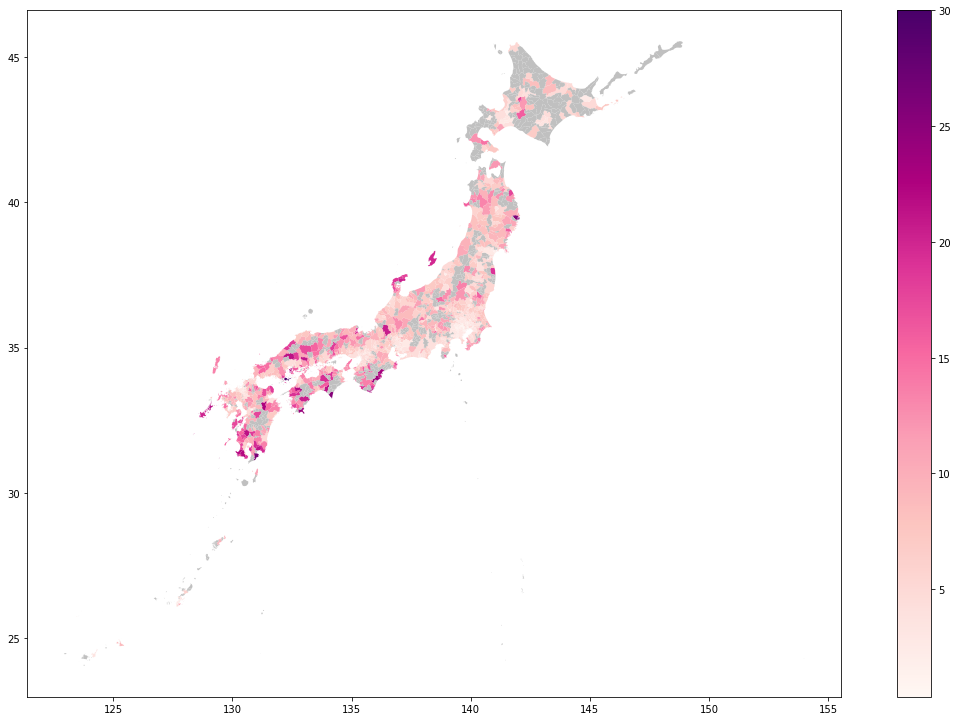

In [93]:
# create a plot 
f = plt.figure()
f.set_size_inches(20,12)

ax1 = f.add_subplot()
df_final.plot(column='empty_homes_ratio', legend=True, cmap='RdPu', figsize=(20, 12), ax=ax1, missing_kwds={'color': '#C0C0C0'})

f.subplots_adjust(top=0.92)

&ensp;&ensp;The mountainous areas in inland Honshu and further west seem to have higher rates or missing data. At the same time, it is possible to see how low the values are around Tokyo and Osaka. 

## Methodology

&ensp;&ensp;Previous research exploring factors related to the occurrence of vacant dwellings, especially with the analysis conducted at the municipal or prefectural level, has mainly deployed statistical methods, notably multiple linear regression (Hirahara 2022, Kanamori et al. 2015). However, due to the complex and non-linear nature of the estimation of vacant houses, limitations regarding its accuracy and precision have been pointed out (Baba et al., 2021). Therefore, four different regression models will be built and tested to predict the vacant housing rate using the variables selected and explored above: linear regression, CART, Decision Tree, and XGBoost. The results of the models will be compared using the R2 value. In addition, due to the extensive range of variables selected, with some having relatively high collinearity, it may be beneficial to conduct principal component analysis (PCA) to consider whether reducing the data dimensions shall be beneficial. 

## Results (Analysis Workflow)
### Data Pre-Processing 

In [94]:
# split the data into training and testing subset - ensure the reproducability 
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(df.drop(['empty_homes_ratio'], axis = 1), df['empty_homes_ratio'], random_state=random_state_split)

**Imputation for missing values and standardisation - usage of pipelines**

In [95]:
# The missing values of a feature will be replaced by the 'mean' value of the feature
# Usage of the RobustScaler as it is robust to outliers
transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', RobustScaler())
])

In [96]:
# apply the transformer to the features
features = df.columns.tolist()
features.remove('empty_homes_ratio')
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', transformer, features)
])

### Comprehensive Analysis

#### Principal Component Analysis 

In [97]:
# separate the independent and dependent variables
X = df.drop('empty_homes_ratio', axis=1).values
Y = df.loc[:,['empty_homes_ratio']].values

# the name list of independent variables
list_var_X = df.columns.tolist()
list_var_X.remove('empty_homes_ratio')

In [98]:
# principle component analysis - making the result reproducable
pca = PCA(random_state=100)  

# impute the missing variables with the mean 
imp_mean = SimpleImputer(missing_values = np.nan, strategy='mean')
X = imp_mean.fit_transform(X)

# standardisation of X
X = RobustScaler().fit_transform(X)

# fit the components
X_new_components = pca.fit_transform(X)

In [99]:
# understanding the results
print(f"Explained variance ratio of each component: {pca.explained_variance_ratio_}")
print(f"Eigenvalues of each component: {pca.explained_variance_}")

Explained variance ratio of each component: [4.56719504e-01 1.62375060e-01 7.23683504e-02 6.71556784e-02
 5.61182554e-02 4.05247221e-02 3.54506661e-02 3.04199571e-02
 2.29355003e-02 1.80699003e-02 1.53642183e-02 1.21532996e-02
 5.28647651e-03 2.72615455e-03 2.09966928e-03 2.32588181e-04
 1.40543590e-24 3.89556779e-25]
Eigenvalues of each component: [8.11207009e+00 2.88404120e+00 1.28537784e+00 1.19279244e+00
 9.96750122e-01 7.19783989e-01 6.29660624e-01 5.40307173e-01
 4.07371231e-01 3.20950378e-01 2.72893132e-01 2.15862072e-01
 9.38962923e-02 4.84208724e-02 3.72934903e-02 4.13113872e-03
 2.49627932e-23 6.91915250e-24]


<AxesSubplot:xlabel='PC'>

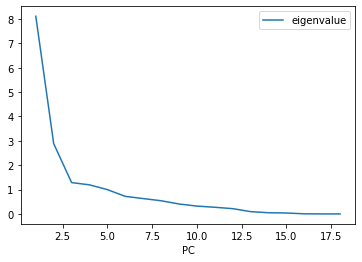

In [100]:
# create a scree plot 
pca_result = pd.DataFrame({'eigenvalue':pca.explained_variance_,
             'PC':list(range(1, pca.n_components_ + 1))})
pca_result.plot.line(x = 'PC', y = 'eigenvalue')

In [101]:
# check the weight of the varibles for the components
# first crete a dataframe
df_PrincipleComp = pd.DataFrame(pca.components_, columns = list_var_X) 

In [102]:
# examination of first component
first_cp = df_PrincipleComp.to_dict(orient='records')[0]

# sort in value order
sorted(((v,k) for k, v in first_cp.items()), reverse=True)

[(0.757514582674695, 'population_density'),
 (0.2548013264110531, 'proportion_apartment'),
 (0.20005099674018142, 'proportion_working_pop'),
 (0.17031408400496745, 'proportion_public_assistance'),
 (0.16227935912689276, 'employment_scale'),
 (0.1560510717546037, 'proportion_tertiary_industry'),
 (0.11454069861653061, 'proportion_new_housing'),
 (0.11077062761848112, 'business_change_rate'),
 (0.07723101911199623, 'proportion_younger_pop'),
 (-0.01259543416866572, 'employment_rate'),
 (-0.06450260781391232, 'house_distribution_ratio'),
 (-0.06813891269236828, 'proportion_secondary_industry'),
 (-0.0950646842842603, 'proportion_single_elderly_household'),
 (-0.15590940672120843, 'proportion_old_housing'),
 (-0.17000937946436348, 'proportion_primary_industry'),
 (-0.17542309657410882, 'proportion_elderly_pop'),
 (-0.21377980560361134, 'proportion_owned'),
 (-0.24998870773275006, 'proportion_detached')]

In [103]:
# examination of second component
second_cp = df_PrincipleComp.to_dict(orient='records')[1]

# sort in value order
sorted(((v,k) for k, v in second_cp.items()), reverse=True)

[(0.38041456791271433, 'proportion_new_housing'),
 (0.35056197164276326, 'business_change_rate'),
 (0.34414144332677443, 'proportion_younger_pop'),
 (0.26182205662236796, 'employment_scale'),
 (0.20312354435102528, 'proportion_working_pop'),
 (0.15520214399087395, 'proportion_secondary_industry'),
 (0.08896446251036276, 'employment_rate'),
 (0.02215213746745283, 'proportion_apartment'),
 (-0.01875654322735289, 'proportion_detached'),
 (-0.036494394098001724, 'proportion_owned'),
 (-0.05041688894568319, 'proportion_tertiary_industry'),
 (-0.08026404518183024, 'house_distribution_ratio'),
 (-0.12995939188658268, 'proportion_primary_industry'),
 (-0.1692169819851585, 'proportion_public_assistance'),
 (-0.2241581955391899, 'proportion_old_housing'),
 (-0.258982547667171, 'proportion_elderly_pop'),
 (-0.36936607951233835, 'proportion_single_elderly_household'),
 (-0.40213536210036416, 'population_density')]

In [104]:
# examination of third component
third_cp = df_PrincipleComp.to_dict(orient='records')[2]

# sort in value order
sorted(((v,k) for k, v in third_cp.items()), reverse=True)

[(0.5778515887873118, 'business_change_rate'),
 (0.3340189488467063, 'proportion_new_housing'),
 (0.29373107910574064, 'proportion_single_elderly_household'),
 (0.21945338958068675, 'proportion_tertiary_industry'),
 (0.16247997936956476, 'proportion_public_assistance'),
 (0.12370071112719389, 'proportion_elderly_pop'),
 (0.12219120993772709, 'house_distribution_ratio'),
 (0.07233916821740663, 'proportion_primary_industry'),
 (0.058479062776693125, 'proportion_apartment'),
 (0.02904848289454892, 'proportion_old_housing'),
 (-0.08103462236261871, 'proportion_younger_pop'),
 (-0.0874502219003055, 'proportion_detached'),
 (-0.13041786978809639, 'proportion_working_pop'),
 (-0.14935596543980587, 'proportion_owned'),
 (-0.15269713989462555, 'population_density'),
 (-0.22655051969208304, 'employment_scale'),
 (-0.32016497336329564, 'proportion_secondary_industry'),
 (-0.35110530204332147, 'employment_rate')]

#### Regression analysis with original data

**Hyperparmeter tuning**

In [105]:
# fix the random_state in regressor so that the result of GridSearchCV is the same in different runs
cart_pipeline = Pipeline(steps = [
  ('preprocessor', preprocessor),
  ('regressor', DecisionTreeRegressor(random_state=100))
])

cart_pipeline.fit(train_x, train_y)

# grid_params is the range of each hyperparameter
grid_params = {
  'regressor__max_depth': [5,10,15,20,25], 
  'regressor__min_samples_split': [2,4,6,8,10,12,14,16,18,20]
}
cart_best = GridSearchCV(cart_pipeline, grid_params)
cart_best.fit(train_x, train_y)
print("Best R2 Score: ", cart_best.best_score_)
print("Best Params: ", cart_best.best_params_)

Best R2 Score:  0.718184294212252
Best Params:  {'regressor__max_depth': 5, 'regressor__min_samples_split': 12}


In [106]:
# fix the random_state in regressor so that the result of GridSearchCV is the same in different runs
rf_pipeline = Pipeline(steps = [
  ('preprocessor', preprocessor),
  ('regressor', RandomForestRegressor(random_state=100))
])

rf_pipeline.fit(train_x, train_y)

# grid_params is the range of each hyperparameter
grid_params = {
  'regressor__max_depth': [5,10,15,20,25], 
  'regressor__min_samples_split': [2,4,6,8,10,12,14,16,18,20]
}
rf_best = GridSearchCV(rf_pipeline, grid_params)
rf_best.fit(train_x, train_y)
print("Best R2 Score: ", rf_best.best_score_)
print("Best Params: ", rf_best.best_params_)

Best R2 Score:  0.7942779101777957
Best Params:  {'regressor__max_depth': 15, 'regressor__min_samples_split': 6}


**comparison of the model results**

In [107]:
regressors = {
    'Linear': LinearRegression(),
    'CART': DecisionTreeRegressor(max_depth=cart_best.best_params_['regressor__max_depth'], min_samples_split=cart_best.best_params_['regressor__min_samples_split'], random_state=100),
    'RF': RandomForestRegressor(max_depth=rf_best.best_params_['regressor__max_depth'], min_samples_split=rf_best.best_params_['regressor__min_samples_split'], random_state=100),
    'XGB': XGBRegressor(random_state = 100)
}

# a dict to store the R2 of training and testing data
dict_results = dict()

for name, regressor in regressors.items():
    pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('regressor', regressor)
           ])
    model = pipeline.fit(train_x, train_y)
    predictions = model.predict(test_x)
    dict_results[name] = [model.score(train_x, train_y), model.score(test_x, test_y), model.score(train_x, train_y) - model.score(test_x, test_y)]
# transform dict_models to dataframe
df_models = pd.DataFrame.from_dict(dict_results, orient='index', columns=['R2_train_data', 'R2_test_data', 'R2_diff'])
df_models

,R2_train_data,R2_test_data,R2_diff
Linear,0.805666,0.811442,-0.005777
CART,0.861550,0.635829,0.225720
RF,0.961952,0.806871,0.155081
XGB,0.999968,0.789129,0.210839


In [108]:
# factor visualisation 
# preprocess
train_x_factor = pd.DataFrame(imp_mean.fit_transform(train_x.values), columns = train_x.columns, index = train_x.index)
train_x_factor = pd.DataFrame(RobustScaler().fit_transform(train_x_factor.values), columns = train_x_factor.columns, index = train_x_factor.index)
test_x_factor = pd.DataFrame(imp_mean.fit_transform(test_x.values), columns = test_x.columns, index = test_x.index)
test_x_factor = pd.DataFrame(RobustScaler().fit_transform(test_x_factor.values), columns = test_x_factor.columns, index = test_x_factor.index)

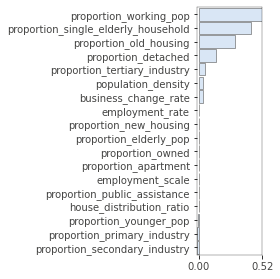

In [109]:
# cart
cart_best_model = DecisionTreeRegressor(max_depth=cart_best.best_params_['regressor__max_depth'], min_samples_split=cart_best.best_params_['regressor__min_samples_split'], random_state=100)
cart_best_model.fit(train_x_factor, train_y)
imp_cart = rfpimp.importances(cart_best_model, test_x_factor, test_y)
viz_cart = rfpimp.plot_importances(imp_cart)
viz_cart.view()

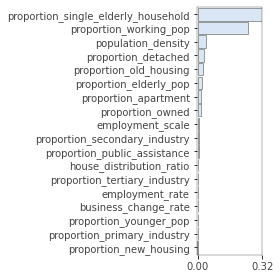

In [110]:
# rf 
rf_best_model = RandomForestRegressor(max_depth=rf_best.best_params_['regressor__max_depth'], min_samples_split=rf_best.best_params_['regressor__min_samples_split'], random_state=100)
rf_best_model.fit(train_x_factor, train_y)
imp_rf = rfpimp.importances(rf_best_model, test_x_factor, test_y)
viz_rf = rfpimp.plot_importances(imp_rf)
viz_rf.view()

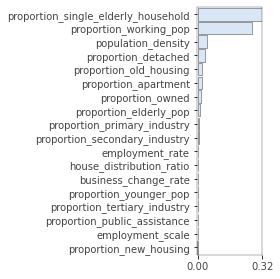

In [111]:
# xgboost
xgb_model = RandomForestRegressor(random_state = 100)
xgb_model.fit(train_x_factor, train_y)
imp_xgb = rfpimp.importances(xgb_model, test_x_factor, test_y)
viz_xgb = rfpimp.plot_importances(imp_xgb)
viz_xgb.view()

#### Regression analysis with PCA data

In [112]:
train_x

,population_density,proportion_younger_pop,proportion_working_pop,proportion_elderly_pop,proportion_single_elderly_household,proportion_public_assistance,employment_rate,business_change_rate,employment_scale,proportion_primary_industry,proportion_secondary_industry,proportion_tertiary_industry,house_distribution_ratio,proportion_owned,proportion_old_housing,proportion_new_housing,proportion_detached,proportion_apartment
municipality_code,,,,,,,,,,,,,,,,,,
21207,177.4,11.326939,56.822673,31.850388,10.077313,0.908631,96.352448,-5.526898,7.840874,2.012543,48.366564,49.620893,0.984807,85.133240,36.605891,3.225806,89.060309,9.957924
10521,358.7,10.910797,60.753301,28.335902,7.241508,0.000000,95.754026,-2.893891,9.874172,17.765495,30.951441,51.283064,1.000000,87.830688,28.571429,1.410935,88.888889,11.287478
22219,219.5,9.824099,51.266491,38.909411,17.565485,6.786028,94.409321,-3.127962,5.516145,5.508146,13.081846,81.410008,0.996988,70.392749,43.705942,2.215509,77.643505,20.342397
43208,174.4,12.122372,53.313933,34.563694,13.873014,2.176924,95.599342,-0.178015,8.200178,16.565887,26.024815,57.409298,0.999476,71.930745,40.556139,2.623295,77.754460,14.165792
17211,580.9,15.573871,59.857711,24.568418,7.552399,0.945607,97.280735,-2.193784,10.324766,1.946150,40.736728,57.317122,0.994269,78.328530,24.322767,4.726225,80.057637,18.674352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31204,1177.6,12.587987,56.989090,30.422924,12.589128,3.324300,96.015589,-3.403982,9.354388,4.132078,25.932350,69.935572,0.983821,70.790916,29.052467,2.505873,76.194205,20.360219
02203,756.9,12.310022,59.843816,27.846162,11.170992,6.707766,94.499650,0.896388,9.325843,3.433838,23.005295,73.560867,0.985045,61.569936,23.290621,3.897922,66.738452,30.235814
13108,12403.1,12.597690,66.180000,21.222309,11.331212,9.510010,96.488868,-0.228117,19.153241,0.079429,16.902387,83.018184,0.997483,46.822518,21.398723,2.988252,11.531183,87.246708


In [113]:
train_x_factor

,population_density,proportion_younger_pop,proportion_working_pop,proportion_elderly_pop,proportion_single_elderly_household,proportion_public_assistance,employment_rate,business_change_rate,employment_scale,proportion_primary_industry,proportion_secondary_industry,proportion_tertiary_industry,house_distribution_ratio,proportion_owned,proportion_old_housing,proportion_new_housing,proportion_detached,proportion_apartment
municipality_code,,,,,,,,,,,,,,,,,,
21207,-0.204157,-0.501556,-0.334517,0.428073,-0.167926,-0.395018,0.396373,-1.368721,-0.428529,-0.294475,1.996282,-1.208528,-1.934982,0.810827,0.793945,-0.129090,0.683956,-0.565360
10521,-0.074671,-0.672526,0.351937,-0.032250,-0.899745,-0.607953,-0.093301,-0.571403,0.306015,1.704965,0.383359,-1.080990,0.778975,0.987577,0.197560,-1.090507,0.676001,-0.503514
22219,-0.174088,-1.118992,-1.304861,1.352655,1.764501,0.982336,-1.193641,-0.642284,-1.268355,0.149203,-1.271654,1.230645,0.240939,-0.155043,1.320970,-0.664289,0.154171,-0.082312
43208,-0.206299,-0.174755,-0.947291,0.783458,0.811608,-0.097796,-0.219875,0.251010,-0.298728,1.552705,-0.072926,-0.610925,0.685305,-0.054266,1.087165,-0.448267,0.159320,-0.369626
17211,0.084027,1.243279,0.195529,-0.525710,-0.819515,-0.386352,1.155968,-0.359399,0.468796,-0.302902,1.289635,-0.617997,-0.244680,0.364949,-0.117812,0.665748,0.266197,-0.159904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31204,0.510195,0.016541,-0.305453,0.241106,0.480283,0.171088,0.120729,-0.725867,0.118239,-0.025454,-0.081490,0.350214,-2.110995,-0.128953,0.233266,-0.510470,0.086918,-0.081483
02203,0.209728,-0.097660,0.193102,-0.096395,0.114313,0.963995,-1.119727,0.576357,0.107927,-0.114078,-0.352582,0.628382,-1.892483,-0.733157,-0.194426,0.226960,-0.351865,0.377893
13108,8.527551,0.020527,1.299668,-0.963979,0.155660,1.620695,0.508002,0.235838,3.658148,-0.539836,-0.917811,1.354040,0.329420,-1.699481,-0.334859,-0.254933,-2.913698,3.029832


In [114]:
# create a new X dataset including three PCs
X_three_pc = X_new_components[:,[0,1,2]]

In [115]:
# split the data into training and testing subset - ensure the reproducability 
random_state_split = 100
train_x_pc, test_x_pc, train_y_pc, test_y_pc = train_test_split(X_three_pc, Y, random_state=random_state_split)

**hyperparmeter tuning**

In [116]:
# fix the random_state in regressor so that the result of GridSearchCV is the same in different runs
cart = DecisionTreeRegressor(random_state=100)

cart.fit(train_x_pc, train_y_pc)

# grid_params is the range of each hyperparameter
grid_params = {
  'max_depth': [5,10,15,20,25], 
  'min_samples_split': [2,4,6,8,10,12,14,16,18,20]
}
cart_best_pc = GridSearchCV(cart, grid_params)
cart_best_pc.fit(train_x_pc, train_y_pc)
print("Best R2 Score: ", cart_best.best_score_)
print("Best Params: ", cart_best.best_params_)

Best R2 Score:  0.718184294212252
Best Params:  {'regressor__max_depth': 5, 'regressor__min_samples_split': 12}


In [117]:
# fix the random_state in regressor so that the result of GridSearchCV is the same in different runs
rf = RandomForestRegressor(random_state=100)

rf.fit(train_x_pc, train_y_pc)

# grid_params is the range of each hyperparameter
grid_params = {
  'max_depth': [5,10,15,20,25], 
  'min_samples_split': [2,4,6,8,10,12,14,16,18,20]
}
rf_best_pc = GridSearchCV(rf, grid_params)
rf_best_pc.fit(train_x_pc, train_y_pc)
print("Best R2 Score: ", rf_best_pc.best_score_)
print("Best Params: ", rf_best_pc.best_params_)

Best R2 Score:  0.7311865731858818
Best Params:  {'max_depth': 5, 'min_samples_split': 4}


**comparison of the model results**

In [118]:
regressors = {
    'Linear': LinearRegression(),
    'CART': DecisionTreeRegressor(max_depth=cart_best_pc.best_params_['max_depth'], min_samples_split=cart_best_pc.best_params_['min_samples_split'], random_state=100),
    'RF': RandomForestRegressor(max_depth=rf_best_pc.best_params_['max_depth'], min_samples_split=rf_best_pc.best_params_['min_samples_split'], random_state=100),
    'XGB': XGBRegressor(random_state = 100)
}

# a dict to store the R2 of training and testing data
dict_results = dict()

for name, regressor in regressors.items():
    model = regressor.fit(train_x_pc, train_y_pc)
    predictions = model.predict(test_x_pc)
    dict_results[name] = [model.score(train_x_pc, train_y_pc), model.score(test_x_pc, test_y_pc), model.score(train_x_pc, train_y_pc) - model.score(test_x_pc, test_y_pc)]
    # transform dict_models to dataframe
df_models = pd.DataFrame.from_dict(dict_results, orient='index', columns=['R2_train_data', 'R2_test_data', 'R2_diff'])
df_models

,R2_train_data,R2_test_data,R2_diff
Linear,0.636400,0.655782,-0.019381
CART,0.811543,0.669270,0.142273
RF,0.827253,0.724109,0.103145
XGB,0.993919,0.707296,0.286624


## Discussion

&ensp;&ensp;Based on the eigenvalues and the scree plot, three components have been decided to be kept. The first component, explaining approximately 46% of the variance, shows a strong positive correlation with population density. The second component, explaining about 16% of the variance, demonstrates a positive correlation with variables such as the proportion of new housing and changes rate of business and a negative correlation with population density. The third component, explaining approximately 7% of the variance, also demonstrate a strong positive correlation with the proportion of new housing and changes rate of business and a negative association with the employment rate. Investigating what these combinations can imply regarding municipal characteristics may be interesting. 

&ensp;&ensp;Generally, Linear regression models yielded the lowest R2 value, with little difference between the training and testing dataset. On the other hand, the XGBoost model generates a high R2 value for the training data, despite hyperparameter tuning not being conducted, perhaps suggesting overfitting along with the substantial difference in the R2 values for the training and testing dataset. Random forest models seem to perform best in terms of the balance between their predictive accuracy and refraining from overrfitting. When compared with the CART model, it can be noticed that it performs much better for the original dataset, highlighting its strength when using a vast dataset, while not being different enough from CART for more simple data. 
Regarding the factors that influence the prediction of vacant house rates in municipalities in Japan, the proportion of the working population and the proportion of elderly single-person households are identified in all models, which may be understood concidering the social problems Japan faces regarding its ageing society. Therefore, these variables are to be closely followed for future predictions. 

&ensp;&ensp;As the analysis deals with a spatial dataset, with some spatial patterns being identified in the exploration of data, it is crucial to consider the topic of spatial cross-validation. When the distribution of the dependent variable is not random and may exhibit patterns of spatial autocorrelation, there is a possibility of data leakage between the testing and training datasets (Ledesma 2021). While this may be advantageous in situations where one is trying to fill in the spatial gaps, such as the areas in which we are missing data on vacant houses, it is in most cases problematic, leading to overestimation of the accuracy of the model which actually does not have high performance (ibid.). Therefore, further research utilising methods of spatial cross-validation and its integration into the scikit-learn’s functions is necessary to address these issues. 


## Conclusion 

&ensp;&ensp;This report has presented the analysis for developing an answer to the research question of “Can the ratio of vacant houses at the municipality level in Japan be predicted based on different regional attributes from various factors?”. The results have provided implications regarding the differing prediction capacity depending on the model and factors that municipalities should be aware of to combat the issue of vacant homes. Furthermore, the limitations of the approach have also been considered, providing opportunities for future research. 

(1995 words)

## References

Akiyama, Y. et al. (2018) ‘Monitoring of spatial distribution of vacant houses using municipal public data in Kagoshima city, Kagoshima prefecture’, *Journal of Architecture and Planning (Transactions of AIJ)* , 83(744), pp. 275–283.


Baba, H. et al. (2020) ‘Learning geographical distribution of vacant houses using closed municipal data: a case study of Wakayama City, Japan’, *ISPRS Annals of the Photogrammetry, Remote Sensing and Spatial Information Sciences*, 6, pp. 1–8.


Baba, H., Akiyama, Y. and Yachida, O. (2021) ‘Developing predictive model for vacant housing distribution using municipality-owned data: Case study in Maebashi City’, *Journal of Japan Society of Civil Engineers, Ser. D3 (Infrastructure Planning and Management)*, 77(2), pp. 62–71.


Hirahara, Y. (2022) ‘Analysis of social maps by municiplaity based on vacant house rate: Based on “Vacant Houses” and “Other Houses” Ratios’, *Journal of the City Planning Institute of Japan*, 57(1), pp. 1–6.


Kanamori, Y., Ariga, T. and Matsuhashi, K. (2015) ‘Factor analysis and estimation of rate of vacant dwellings’, *Journal of the City Planning Institute of Japan*, 50(3), pp. 1017–1024.
Mashita, M. and Akiyama, Y. (2020) ‘The recent trend of housing vacancy studies in Japan’, *Geographical Space*, 13(1), pp. 1–26.

Ledesma, C. (2021) 'Spatial cross-validation using scikit-learn', Medium, 15 April. Available at: https://towardsdatascience.com/spatial-cross-validation-using-scikit-learn-74cb8ffe0ab (Accessed: 24 April 2023).


Mizusawa, K., Tamura, S. and Tanaka, T. (2022) ‘Analysis of occurence factors of vacant houses by interpretability methods in machine learning: Aiming to development of tools that support measures to solve vacant house problems, which is the best fit for the place’, *Journal of the City Planning Institute of Japan*, 57(3), pp. 1377–1384.


Oda, T., Morimoto, A. and Asano, S. (2018) ‘Study on occurencee of the vacant houses focuing on regional characteristics and attributes of property’, *Journal of the City Planning Institute of Japan*, 53(3), pp. 1074–1079.


Pak, J.H. and Jewell, E. (2019) ‘South Korea and Japan have more in common than they think’, The Brookings Institution, 5 September. Available at: https://www.brookings.edu/blog/order-from-chaos/2019/09/05/south-korea-and-japan-have-more-in-common-than-they-think/ (Accessed: 24 April 2023).


Sayuda, K. et al. (2022) ‘Accuracy of vacant housing detection models: An empirical evaluation using municipal and national census datasets’, *Transactions in GIS*, 26(7), pp. 3003–3027. Available at: https://doi.org/10.1111/tgis.12992.


Statistics Bureau of Japan (2020) *2018 Housing and Land Survey special tabulation*, Statistics Bureau of Japan. Available at: https://www.stat.go.jp/data/jyutaku/2018/tokubetsu.html (Accessed: 23 April 2023).


Yoo, H. and Kwon, Y. (2019) ‘Different factors affecting vacant housing according to regional characteristics in South Korea’, Sustainability, 11(24), p. 6913.


Yu, H. and Lee, J. (2023) ‘Analysis of factors affecting the occurrence of vacant houses according to vacant house classification: Shizuoka Prefecture, Japan’, *Applied Geography*, 151, p. 102872.

